## Логистическая регрессия и случайный лес.

В этом проекте:
- используется логистическая регрессия из бибилиотеки scikit-learn (часть 1);
- реализуется собственная логистическая регрессия для задачи бинарной классификации (часть 2);
- реализуется бутстрэппинг данных и реализуется модель случайного леса (часть 3).

In [2]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
import random
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [6]:
train = pd.read_csv('train.xls')
train.head(5)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Заменим целевую переменную, отделим её в отдельную переменную и удалим из исходной выборки.

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print(train.columns)
target = train['price_range'].to_numpy()
print((target))
for i in range(target.shape[0]):
    if target[i] == 0 or target[i] == 1:
        target[i] = 0
    else:
        target[i] = 1


Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
[1 2 2 ... 3 0 3]


In [11]:
print((target))
try:
    del train['price_range']
except:
    print('Already deleated')

[0 1 1 ... 1 0 1]


Разделим выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. 

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=13, stratify=target)

## Часть 1. Логистическая регрессия.

В этой части будем обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Нормируем данные.

In [16]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)
print(X_train_scaled)

[[-1.17178822  1.00286124  0.0792817  ...  0.5740511   0.97321571
   0.97460798]
 [-1.52597525 -0.99714693 -1.27430833 ... -1.7420052  -1.02752143
  -1.02605357]
 [ 0.0156465   1.00286124  1.55592537 ...  0.5740511   0.97321571
   0.97460798]
 ...
 [-1.17405865  1.00286124 -1.27430833 ...  0.5740511   0.97321571
   0.97460798]
 [-0.08198197  1.00286124  1.80203265 ...  0.5740511   0.97321571
  -1.02605357]
 [ 0.38118568 -0.99714693  1.67897901 ...  0.5740511   0.97321571
   0.97460798]]


Обучим логистическую регрессию. Сделаем предсказания для тестовой части, посчитаем по ним ROC-AUC и Accuracy (порог 0.5).

In [20]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
pred = lr.predict(X_test_scaled)
pred_prob = lr.predict_proba(X_test_scaled)

In [22]:
accuracy = accuracy_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred_prob[:,1])
print('Accuracy: ', accuracy, 'ROC_AUC: ', roc_auc)

Accuracy:  0.9783333333333334 ROC_AUC:  0.9991777777777777


**По обеим метрикам получается хороший результат. То есть классиифкация осуществляется хорошо.**

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуем с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

In [28]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
coefs = lr.coef_
intercept = lr.intercept_

b = np.array([], dtype='float64')
print(coefs.reshape(-1,1).shape, X_test_scaled[0,:].shape)
for i in range(X_test_scaled.shape[0]):
    tmp = intercept + X_test_scaled[i,:].dot(coefs.reshape(-1,1))
    b = np.append(b, tmp)

(20, 1) (20,)


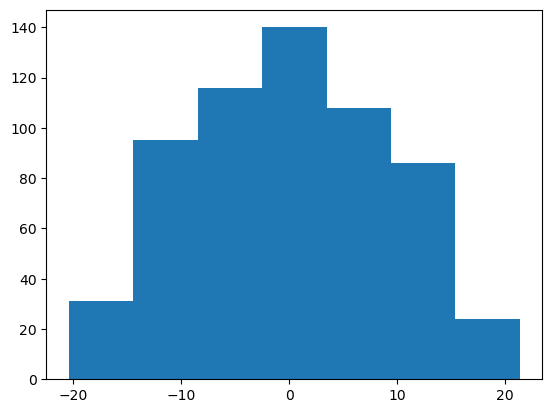

In [30]:
plt.hist(b, bins=7)
plt.show()

**Эти значения совсем не напоминают вероятности классов. По этой причине и нужна сигмоида**

Реализуем сигмоиду и постройте её график.

In [34]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def sigmoid(x):
    sigma = 1 / (1 + np.exp(-x))
    return sigma

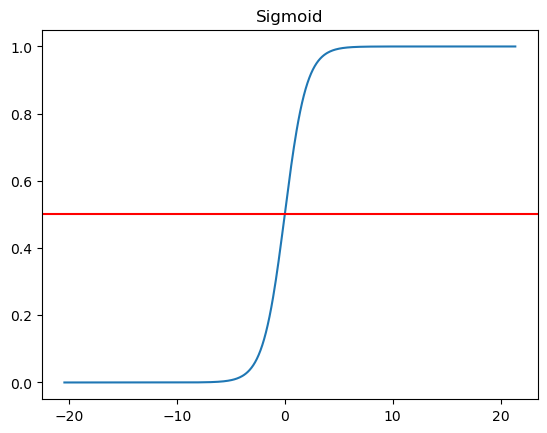

In [36]:
dots = np.linspace(b.min(), b.max(), 500)
sigma = sigmoid(dots)

plt.plot(dots, sigma)
plt.title('Sigmoid')
plt.axhline(0.5, color='r')
plt.show()

Применим реализованную сигмоиду к $b(x)$. Мы должны получить вероятности принадлежности к положительному классу. Проверим, что наши значения совпали с теми, которые получены с помощью `predict_proba`.

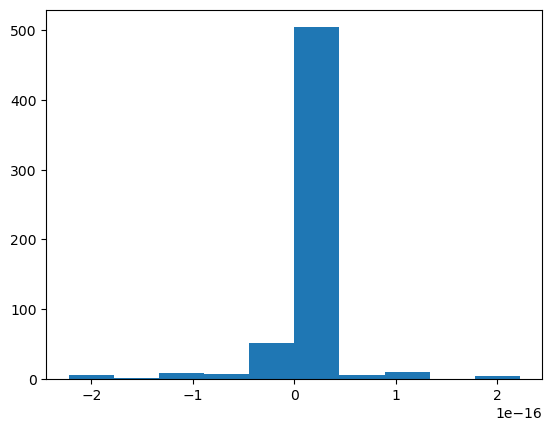

In [39]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
my_probabilities = sigmoid(b)
error = my_probabilities - pred_prob[:,1]
plt.hist(error, bins=10)
plt.show()

**Отличия в 16 цифре после запятой несущественны**

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Построим для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

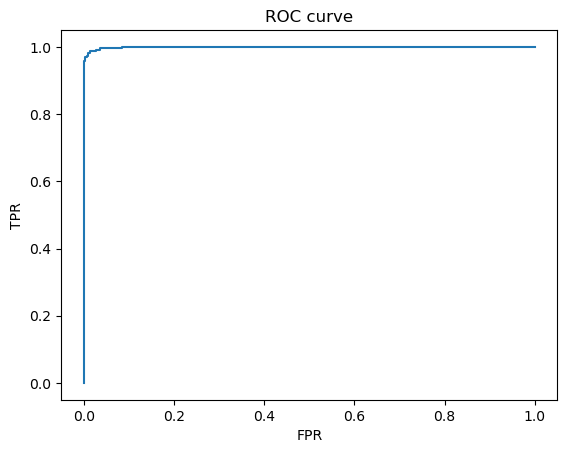

In [41]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fpr, tpr, thr = roc_curve(y_test, my_probabilities)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

**При малом значении ложнопозитивных резльтатов очень много истиннопозитивных. Все хорошо**

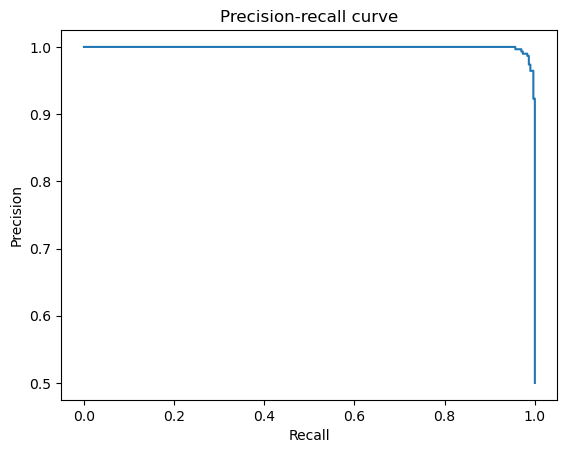

In [43]:
precision, recall, thr = precision_recall_curve(y_test, my_probabilities)
plt.plot(recall, precision)
plt.title("Precision-recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**Precision = tp / (tp + fp), Recall = tp / (tp + fn)**

### Часть 2. Обучение логистической регрессии.

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

В качестве критерия останова используется (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max_iter
- для ускорения вычислений используется декоратор @njit из библиотеки numba

In [45]:
@njit
def logit(x, w):
    return np.dot(x, w)

@njit
def sigmoid(x):
    #x = np.array(x, dtype='float128')
    sigma = 1. / (1. + np.exp(-x))
    return sigma

@njit
def grad_accelerated(X, y, W, lambda_2):
    l = len(y)
    predictions = np.array([sigmoid(np.dot(X_cur, W)) for X_cur in X])
    tmp = np.multiply(y, 1/(1 + np.exp(-np.multiply(y, predictions))))
    gradient1 = - 1/l * X.T @ tmp 
    #gradient2 = np.array([0]*(len(self.w)-1))
    gradient2 = np.concatenate((np.array([0]), lambda_2 * W[1:]*0), axis=0)
    return gradient1 + gradient2

@njit
def loss_accelerated(X, y, W, lambda_2):
    l = len(y)
    predictions = np.array([sigmoid(np.dot(X_cur, W)) for X_cur in X])
    tmp = np.log(1 + np.exp(-np.multiply(y, predictions)))
    loss = 1/l*np.sum(tmp) + lambda_2/2 * np.dot(0*W[1:], W[1:])
    return loss

In [47]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None

    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        n, k = X.shape        
        if self.w is None:
            np.random.seed(75)
            # Вектор столбец в качестве весов
            self.w = np.random.randn(k + 1)
            #self.w = np.array([0.]*(k+1), dtype='float128')
            
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)       
        for i in range(self.max_iter):
            self.loss_history.append(self.calc_loss(X_train, y))
            grad = self.calc_gradient(X_train, y)
            self.w -= self.alpha * grad
            if np.sqrt(logit(grad, grad)) < self.tolerance:
                break
                
        return self

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        n, k = X.shape
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        probs = np.array([[0.]*2 for i in range(X.shape[0])])
        if self.w is None:
            raise Exception('Not trained yet')
        else:
            for i in range(X.shape[0]):
                probs[i,1] = sigmoid(logit(self.w, X[i, :]))
                probs[i,0] = 1 - probs[i,1]
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        ans = np.array([0]*probs.shape[0])
        for i in range(probs.shape[0]):
            if probs[i, 1] > 0.5:
                ans[i] = 1
            else:
                ans[i] = 0
        return ans

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        return grad_accelerated(X, y, self.w, self.lambda_2)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return loss_accelerated(X, y, self.w, self.lambda_2)
        

1. Применим логистическую регресиию на той же выборке.
2. Посчитаем качество по тем же метрикам.
3. Визуализируем изменение значений функции потерь от номера итераций.

In [50]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=13, stratify=target)

In [52]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y_train[y_train == 0] = -1
mylr = LogReg(max_iter=10000, alpha=1e-2, lambda_2=0.1)
mylr.fit(X_train_scaled, y_train)

/tmp/ipykernel_24768/505392063.py:24: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  predictions = np.array([sigmoid(np.dot(X_cur, W)) for X_cur in X])


LogReg(alpha=0.01, lambda_2=0.1, max_iter=10000)

In [54]:
pred = mylr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, pred)
print('Accuracy = ', accuracy)

pred_prob = mylr.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, pred_prob[:,1])
print('ROC-AUC = ', roc_auc)


Accuracy =  0.9
ROC-AUC =  0.9878666666666667


/tmp/ipykernel_24768/505392063.py:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  return np.dot(x, w)


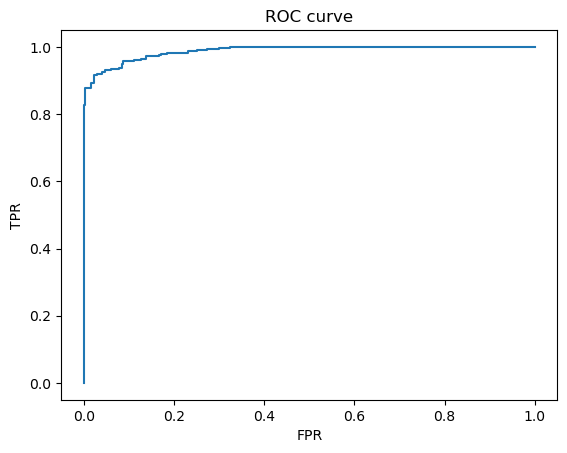

In [56]:
fpr, tpr, thr = roc_curve(y_test, pred_prob[:,1])
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

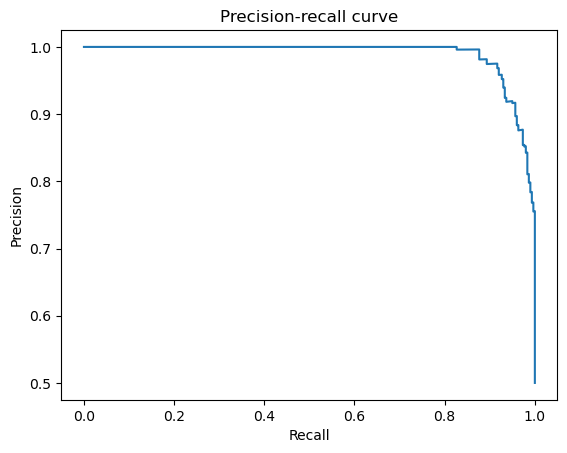

In [58]:
precision, recall, thr = precision_recall_curve(y_test, pred_prob[:,1])
plt.plot(recall, precision)
plt.title("Precision-recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

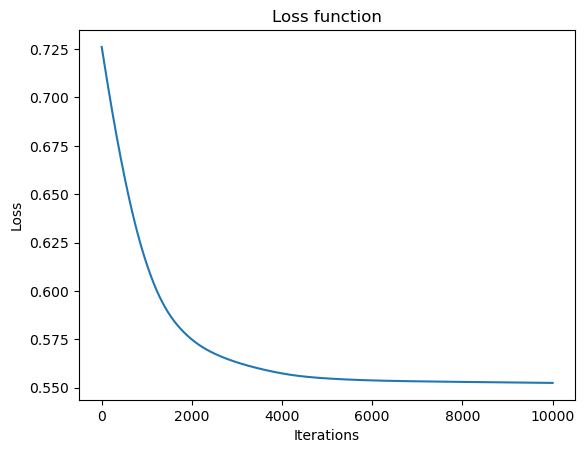

In [60]:
x = np.linspace(1, len(mylr.loss_history), len(mylr.loss_history))
plt.plot(x, mylr.loss_history)
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.xlim(1000, 2000)
plt.show()

## Часть 3. Случайные леса.

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучим решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5).

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=13, stratify=target)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [24]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
np.random.seed(13)
dtc = DecisionTreeClassifier(min_samples_leaf=5, random_state=13)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, random_state=13)

In [26]:
pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

pred_prob = dtc.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_prob[:,1])
print(roc_auc)

0.935
0.9585666666666667


### 2.1 Сэмплирование обучающей выборки

Осуществим бутстрап

In [30]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
np.random.seed(13)  # для одинакового бутстрапа в каждом запуске
estimators = 100
predictions = np.array([[0]*estimators for j in range(len(y_test))])
aucs = np.array([[0]*estimators for j in range(len(y_test))])
for i in range(estimators):
    samp = np.random.randint(0, X_train.shape[0], size=X_train.shape[0])
    dtc = DecisionTreeClassifier(min_samples_leaf=3)
    dtc.fit(X_train[samp], y_train[samp])
    pred = dtc.predict(X_test)
    predictions[:, i] = pred
    pred_prob = dtc.predict_proba(X_test)[:,1]
    aucs[:, i] = pred_prob
tmp = np.sum(predictions,axis=1)/estimators
tmp[tmp < 0.5] = 0
tmp[tmp >= 0.5] = 1
accuracy = accuracy_score(y_test, tmp)
print(accuracy)
roc_auc = roc_auc_score(y_test, np.mean(aucs, axis=1))
print(roc_auc)

0.9566666666666667
0.99515


**Качество улучшилось по сравнению с одиночным решающим деревом**

### 2.2 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

In [32]:
np.random.seed(13)  # для воспроизводимости построения случайных подмножеств признаков

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
dtc = DecisionTreeClassifier(min_samples_leaf=3, max_features='sqrt')
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Accuracy = ', accuracy)

pred_prob = dtc.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_prob[:,1])
print('roc-auc = ', roc_auc)

Accuracy =  0.8566666666666667
roc-auc =  0.8940388888888889


**Качество ухудшилось при выборе случайного количества sqrt(n) признаков**

### 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

In [34]:
np.random.seed(13)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
estimators = 100
predictions = np.array([[0]*estimators for j in range(len(y_test))])
aucs = np.array([[0]*estimators for j in range(len(y_test))])
for i in range(estimators):
    samp = np.random.randint(0, X_train.shape[0], size=X_train.shape[0])
    dtc = DecisionTreeClassifier(min_samples_leaf=3, max_features='sqrt')
    dtc.fit(X_train[samp], y_train[samp])
    pred = dtc.predict(X_test)
    predictions[:, i] = pred
    pred_prob = dtc.predict_proba(X_test)[:,1]
    aucs[:, i] = pred_prob
tmp = np.sum(predictions,axis=1)/estimators
tmp[tmp < 0.5] = 0
tmp[tmp >= 0.5] = 1
accuracy = accuracy_score(y_test, tmp)
print('Accuracy = ', accuracy)
roc_auc = roc_auc_score(y_test, np.mean(aucs, axis=1))
print('roc-auc = ', roc_auc)

Accuracy =  0.9483333333333334
roc-auc =  0.9920555555555556


**Качество почти такое же (чуть меньше значение в 3 знаке после запятой), как и в случае бутстрапа без случайного выбора признаков**

Воспользуемся scikit-learn реализацией `RandomForestClassifier`. 

In [36]:
from sklearn.ensemble import RandomForestClassifier
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
np.random.seed(13)

rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features='sqrt')
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Accuracy = ', accuracy)

pred_prob = dtc.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_prob[:,1])
print('roc-auc = ', roc_auc)

Accuracy =  0.9483333333333334
roc-auc =  0.7998277777777778


**Качество по метрике accuracy_score совпало с самописной реализацией бутстрапа и выбора случайных признаков. А вот по метрике roc-auc качество оказалось хуже**